In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
!pip install openpyxl

     |████████████████████████████████| 251 kB 20.6 MB/s eta 0:00:01


In [3]:
up, down = True, False

In [4]:
np.set_printoptions(precision=3)

pd.set_option("expand_frame_repr", True)
pd.set_option("colheader_justify", "right")

pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 75)

pd.set_option("display.precision", 4)

In [5]:
# read in file 
nutrients_dataset = "Food And Nutrient Database For Dietary Studies/2021-2023 FNDDS At A Glance - FNDDS Nutrient Values.xlsx"  # Replace with your file path
df = pd.read_excel(nutrients_dataset, sheet_name=0, header=1)

# list of key words to check in the WWEIA Category description
keywords = ['milk', 'dips', 'spread', 'cream', 'butter', 'sauces', 'dressing',
            'ice cream', 'yogurt', 'formula', 'drinks', 'liquor', 'tea', 'coffee',
            'milk', 'water', 'juice', 'soups', 'beverages', 'wine', 'beer']
# check for keywords and make a new column identifying if an entry is a liquid
df['Is Liquid'] = df['WWEIA Category description'].apply(lambda x: 1 if any(keyword in str(x).lower() for keyword in keywords) else 0)

#Drop all liquids from the dataset to create a dataset of only solids.  The new dataset is called df_solids
df_solids = df[df['Is Liquid'] == 0]
df_solids.head(35)

,Food code,Main food description,WWEIA Category number,WWEIA Category description,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),"Fatty acids, total saturated (g)","Fatty acids, total monounsaturated (g)","Fatty acids, total polyunsaturated (g)",Cholesterol (mg),Retinol (mcg),"Vitamin A, RAE (mcg_RAE)","Carotene, alpha (mcg)","Carotene, beta (mcg)","Cryptoxanthin, beta (mcg)",Lycopene (mcg),Lutein + zeaxanthin (mcg),Thiamin (mg),Riboflavin (mg),Niacin (mg),Vitamin B-6 (mg),Folic acid (mcg),"Folate, food (mcg)","Folate, DFE (mcg_DFE)","Folate, total (mcg)","Choline, total (mg)",Vitamin B-12 (mcg),"Vitamin B-12, added\n(mcg)",Vitamin C (mg),Vitamin D (D2 + D3) (mcg),Vitamin E (alpha-tocopherol) (mg),"Vitamin E, added\n(mg)",Vitamin K (phylloquinone) (mcg),Calcium (mg),Phosphorus (mg),Magnesium (mg),Iron\n(mg),Zinc\n(mg),Copper (mg),Selenium (mcg),Potassium (mg),Sodium (mg),Caffeine (mg),Theobromine (mg),Alcohol (g),4:0\n(g),6:0\n(g),8:0\n(g),10:0\n(g),12:0\n(g),14:0\n(g),16:0\n(g),18:0\n(g),16:1\n(g),18:1\n(g),20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g),Is Liquid
79,11480000,"Baby Toddler food, NFS",9007,Baby food: mixtures,75,4.90,9.08,4.47,1.1,2.15,0.601,0.877,0.504,18,1,80,183,855,4,0,298,0.025,0.083,1.294,0.112,0,11,11,11,20.0,0.24,0.0,12.4,0.2,0.37,0.05,6.1,23,48,14,0.62,0.65,0.064,3.7,179,27,0,0,0.0,0.001,0.000,0.000,0.000,0.001,0.018,0.375,0.143,0.065,0.745,0.005,0.000,0.421,0.023,0.003,0.010,0.000,0.003,0.000,83.24,0
201,11810000,"Milk, dry, not reconstituted",9999,Not included in a food category,362,36.16,51.98,51.98,0.0,0.77,0.499,0.200,0.030,20,653,653,0,1,0,0,0,0.415,1.550,0.951,0.361,0,50,50,50,169.2,4.03,0.0,6.8,11.0,0.00,0.00,0.1,1257,968,110,0.32,4.08,0.041,27.3,1794,535,0,0,0.0,0.028,0.006,0.007,0.018,0.014,0.083,0.235,0.085,0.022,0.167,0.000,0.000,0.019,0.011,0.000,0.000,0.000,0.000,0.000,3.16,0
202,11825000,"Whey, sweet, dry",9999,Not included in a food category,353,12.93,74.46,74.46,0.0,1.07,0.684,0.297,0.034,6,8,8,0,2,0,0,0,0.519,2.208,1.258,0.584,0,12,12,12,225.0,2.37,0.0,1.5,0.0,0.02,0.00,0.1,796,932,176,0.88,1.97,0.070,27.2,2080,1079,0,0,0.0,0.059,0.009,0.010,0.018,0.012,0.104,0.326,0.097,0.033,0.251,0.000,0.000,0.025,0.009,0.000,0.000,0.000,0.000,0.000,3.19,0
203,11830150,"Cocoa powder, not reconstituted",9999,Not included in a food category,228,19.60,57.90,1.75,37.0,13.70,8.070,4.570,0.440,0,0,0,0,0,0,0,38,0.078,0.241,2.185,0.118,0,32,32,32,12.0,0.00,0.0,0.0,0.0,0.10,0.00,2.5,128,734,499,13.86,6.81,3.788,14.3,1524,21,230,2057,0.0,0.000,0.000,0.000,0.000,0.000,0.020,3.690,4.250,0.000,4.570,0.000,0.000,0.440,0.000,0.000,0.000,0.000,0.000,0.000,3.00,0
204,11830160,"Chocolate beverage powder, dry mix, not reconstituted",9999,Not included in a food category,400,4.55,90.28,81.82,4.5,2.27,2.273,0.000,0.000,0,0,0,0,0,0,0,0,0.009,0.056,0.199,0.909,0,4,4,4,3.3,0.00,0.0,27.3,0.0,0.04,0.00,0.9,455,86,53,0.00,6.82,0.909,1.9,280,136,8,277,0.0,0.000,0.000,0.000,0.000,0.000,0.006,1.082,1.162,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.10,0
205,11830165,"Chocolate beverage powder, light, dry mix, not reconstituted",9999,Not included in a food category,350,9.09,68.31,27.27,9.1,4.50,0.000,2.119,1.831,0,0,0,0,0,0,0,0,1.500,0.350,25.600,1.818,0,7,7,7,266.9,0.00,0.0,54.5,0.0,0.00,0.00,0.0,909,500,410,3.27,13.64,1.818,21.8,1705,500,1,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.055,2.045,0.000,0.000,1.624,0.203,0.000,0.000,0.000,0.000,0.000,7.40,0
206,11830260,"Milk, malted, dry mix, not reconstituted",9999,Not included in a food category,372,0.00,92.96,72.73,0.0,0.00,0.000,0.000,0.000,0,1365,1365,0,0,0,0,0,1.364,0.000,18.182,1.818,0,0,0,0,0.0,0.00,0.0,54.5,9.1,12.27,12.27,0.0,909,0,218,16.36,13.64,1.818,0.0,0,530,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.28,0
207,11830400,"Strawberry b

In [6]:
features = list(df_solids.columns)

# removed '\n' from some columns for visualization purposes'
feat_list = ['Food code',
 'Main food description',
 'WWEIA Category number',
 'WWEIA Category description',
 'Energy (kcal)',
 'Protein (g)',
 'Carbohydrate (g)',
 'Sugars, total(g)',
 'Fiber, total dietary (g)',
 'Total Fat (g)',
 'Fatty acids, total saturated (g)',
 'Fatty acids, total monounsaturated (g)',
 'Fatty acids, total polyunsaturated (g)',
 'Cholesterol (mg)',
 'Retinol (mcg)',
 'Vitamin A, RAE (mcg_RAE)',
 'Carotene, alpha (mcg)',
 'Carotene, beta (mcg)',
 'Cryptoxanthin, beta (mcg)',
 'Lycopene (mcg)',
 'Lutein + zeaxanthin (mcg)',
 'Thiamin (mg)',
 'Riboflavin (mg)',
 'Niacin (mg)',
 'Vitamin B-6 (mg)',
 'Folic acid (mcg)',
 'Folate, food (mcg)',
 'Folate, DFE (mcg_DFE)',
 'Folate, total (mcg)',
 'Choline, total (mg)',
 'Vitamin B-12 (mcg)',
 'Vitamin B-12, added(mcg)',
 'Vitamin C (mg)',
 'Vitamin D (D2 + D3) (mcg)',
 'Vitamin E (alpha-tocopherol) (mg)',
 'Vitamin E, added(mg)',
 'Vitamin K (phylloquinone) (mcg)',
 'Calcium (mg)',
 'Phosphorus (mg)',
 'Magnesium (mg)',
 'Iron(mg)',
 'Zinc(mg)',
 'Copper (mg)',
 'Selenium (mcg)',
 'Potassium (mg)',
 'Sodium (mg)',
 'Caffeine (mg)',
 'Theobromine (mg)',
 'Alcohol (g)',
 '4:0(g)',
 '6:0(g)',
 '8:0(g)',
 '10:0(g)',
 '12:0(g)',
 '14:0(g)',
 '16:0(g)',
 '18:0(g)',
 '16:1(g)',
 '18:1(g)',
 '20:1(g)',
 '22:1(g)',
 '18:2(g)',
 '18:3(g)',
 '18:4(g)',
 '20:4(g)',
 '20:5 n-3(g)',
 '22:5 n-3(g)',
 '22:6 n-3(g)',
 'Water(g)',
 'Is Liquid']

len(features)

70

In [7]:
new_df = df_solids.drop(columns = ['Food code', 'WWEIA Category number', 'WWEIA Category description'])
revised_df = new_df.groupby(by = ['Main food description']).mean()

revised_df.head(3)

,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),"Fatty acids, total saturated (g)","Fatty acids, total monounsaturated (g)","Fatty acids, total polyunsaturated (g)",Cholesterol (mg),Retinol (mcg),"Vitamin A, RAE (mcg_RAE)","Carotene, alpha (mcg)","Carotene, beta (mcg)","Cryptoxanthin, beta (mcg)",Lycopene (mcg),Lutein + zeaxanthin (mcg),Thiamin (mg),Riboflavin (mg),Niacin (mg),Vitamin B-6 (mg),Folic acid (mcg),"Folate, food (mcg)","Folate, DFE (mcg_DFE)","Folate, total (mcg)","Choline, total (mg)",Vitamin B-12 (mcg),"Vitamin B-12, added\n(mcg)",Vitamin C (mg),Vitamin D (D2 + D3) (mcg),Vitamin E (alpha-tocopherol) (mg),"Vitamin E, added\n(mg)",Vitamin K (phylloquinone) (mcg),Calcium (mg),Phosphorus (mg),Magnesium (mg),Iron\n(mg),Zinc\n(mg),Copper (mg),Selenium (mcg),Potassium (mg),Sodium (mg),Caffeine (mg),Theobromine (mg),Alcohol (g),4:0\n(g),6:0\n(g),8:0\n(g),10:0\n(g),12:0\n(g),14:0\n(g),16:0\n(g),18:0\n(g),16:1\n(g),18:1\n(g),20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g),Is Liquid
Main food description,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Abalone,177,21.24,7.46,0.00,0.0,6.12,0.877,2.326,2.116,106,2,2,0,0,0,0,0,0.201,0.118,1.770,0.168,0,5,5,5,80.7,0.77,0.0,2.0,0.0,5.95,0.0,33.8,39,236,60,3.97,1.02,0.243,55.6,310,574,0,0,0.0,0.0,0.0,0.0,0.000,0.000,0.031,0.624,0.175,0.043,2.245,0.035,0.0,1.768,0.226,0.007,0.000,0.061,0.051,0.0,62.72,0
"Adobo, with noodles",172,16.89,8.14,0.03,0.4,7.66,2.479,3.469,0.973,72,4,4,0,0,0,0,0,0.192,0.204,3.059,0.216,0,3,3,3,57.1,0.43,0.0,0.0,0.3,0.20,0.0,0.0,15,149,18,0.99,2.39,0.085,23.1,200,510,0,0,0.0,0.0,0.0,0.0,0.004,0.004,0.071,1.677,0.697,0.353,3.072,0.040,0.0,0.867,0.046,0.000,0.040,0.000,0.000,0.0,65.27,0
"Adobo, with rice",181,17.69,8.86,0.03,0.2,7.94,2.580,3.607,1.022,75,4,4,0,0,0,0,0,0.242,0.213,3.589,0.250,17,4,33,21,59.2,0.44,0.0,0.0,0.4,0.21,0.0,0.0,18,161,21,1.34,2.54,0.096,24.6,216,522,0,0,0.0,0.0,0.0,0.0,0.005,0.004,0.074,1.749,0.722,0.366,3.196,0.041,0.0,0.909,0.050,0.000,0.041,0.000,0.000,0.0,63.34,0


In [8]:
def scaled_nutrient_data(data):
    # function to drop unnecessary columns and scale data
    scaled_data = StandardScaler().fit_transform(data)
    
    return scaled_data

In [9]:
scaled_nutrient_data(revised_df)

array([[-0.296,  1.492, -0.705, ..., -0.144,  0.266,  0.   ],
       [-0.334,  0.941, -0.675, ..., -0.144,  0.365,  0.   ],
       [-0.266,  1.042, -0.642, ..., -0.144,  0.29 ,  0.   ],
       ...,
       [ 0.393, -1.039,  0.526, ..., -0.144, -0.258,  0.   ],
       [-1.359, -1.069, -0.706, ..., -0.144,  1.249,  0.   ],
       [ 1.568,  0.082,  2.309, ..., -0.144, -1.987,  0.   ]])

In [10]:
def nutrient_PCA():
    # function to perform PCA on nutrient data
    
    scaled_data = scaled_nutrient_data(revised_df)
    pca = PCA(n_components = 20, random_state = 0).fit(scaled_data)
    
    return pca

In [11]:
# percentage of variance explained by the 20 Principal Components
print(nutrient_PCA().explained_variance_ratio_ * 100)
print(f'Total Explained Variance: {sum(nutrient_PCA().explained_variance_ratio_ * 100):.3f}%')

[15.8   10.529  8.057  7.216  5.121  4.658  4.082  3.301  2.981  2.617
  2.463  2.317  2.019  1.944  1.863  1.769  1.626  1.543  1.494  1.44 ]
Total Explained Variance: 82.841%


In [12]:
def plot_PCA(pca):
    # plot PCA Heatmap    
    feature_list = [x for x in feat_list if x not in ['Food code', 'WWEIA Category number', 'WWEIA Category description', 'Main food description']]
    
    pc_names = []
    
    for i in range(1, 21):
        pc_names.append(f'PC{i}')
    
    fig, ax = plt.subplots(figsize = ((15,20)))
    
    plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
    plt.xticks(np.arange(0, len(feature_list), 1), feature_list, rotation = 90, fontsize = 10)
    plt.yticks(np.arange(0, 20, 1), pc_names, fontsize = 10)
    plt.tight_layout()
    plt.title('Principal Component Loadings for Solids')
    plt.colorbar(shrink = .25)
    return

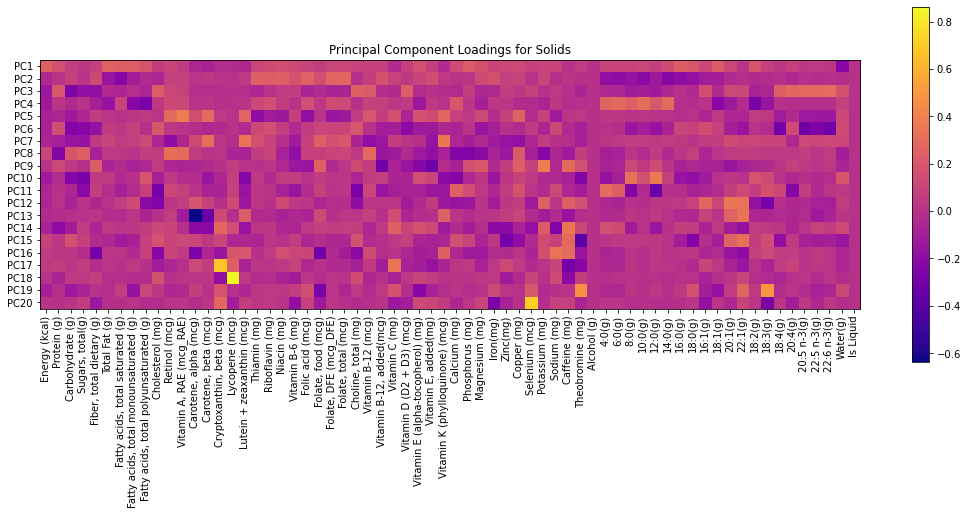

In [13]:
plot_PCA(nutrient_PCA())

In [14]:
feats = [x for x in feat_list if x not in ['Food code', 'WWEIA Category number', 'WWEIA Category description', 'Main food description']]

for ind, feat in enumerate(abs(nutrient_PCA().components_), start = 1):
    x = max(feat)
    max_index = list(feat).index(x)
    
    print(f'Most important feature for PC{ind}: {feats[max_index]} - {x * 100:.2f}% of component explained')

Most important feature for PC1: Total Fat (g) - 25.85% of component explained
Most important feature for PC2: Folate, DFE (mcg_DFE) - 27.71% of component explained
Most important feature for PC3: 22:6 n-3(g) - 29.83% of component explained
Most important feature for PC4: 10:0(g) - 30.20% of component explained
Most important feature for PC5: Vitamin A, RAE (mcg_RAE) - 39.04% of component explained
Most important feature for PC6: 20:5 n-3(g) - 31.38% of component explained
Most important feature for PC7: Vitamin K (phylloquinone) (mcg) - 34.75% of component explained
Most important feature for PC8: Retinol (mcg) - 30.83% of component explained
Most important feature for PC9: Potassium (mg) - 38.13% of component explained
Most important feature for PC10: 12:0(g) - 36.12% of component explained
Most important feature for PC11: 12:0(g) - 32.56% of component explained
Most important feature for PC12: 20:1(g) - 35.17% of component explained
Most important feature for PC13: Carotene, alpha (m

In [15]:
def pca_manifold(df):
    
    # get data
    data = scaled_nutrient_data(df)
    
    # perform PCA
    x_pca = PCA(n_components = 20, random_state = 0).fit_transform(data)
    
    return x_pca

In [16]:
pca_manifold(revised_df)

array([[-0.098,  0.483,  2.259, ...,  0.272, -0.111,  1.244],
       [-0.645, -0.442,  1.355, ..., -0.341,  0.092,  0.097],
       [-0.321, -0.144,  1.369, ..., -0.342,  0.147,  0.112],
       ...,
       [-0.601, -0.455, -1.135, ..., -0.314, -0.113, -0.311],
       [-3.596,  0.225, -0.024, ..., -0.048,  0.017,  0.158],
       [ 0.935,  0.414, -2.198, ...,  0.055, -1.173,  1.055]])

In [17]:
def kmeans_clusters(n_clusters):
    # get PCA output
    data = pca_manifold(revised_df)
    
    # perform clustering
    kmeans = KMeans(n_clusters = n_clusters, max_iter = 1000, random_state = 0)
    clusters = kmeans.fit_predict(data)
    
    return clusters

The average silhouette score for solids with 2 clusters is: 0.41839000241258756
The average silhouette score for solids with 3 clusters is: 0.32694560423837643
The average silhouette score for solids with 4 clusters is: 0.19213908097580468
The average silhouette score for solids with 5 clusters is: 0.20811089117087211


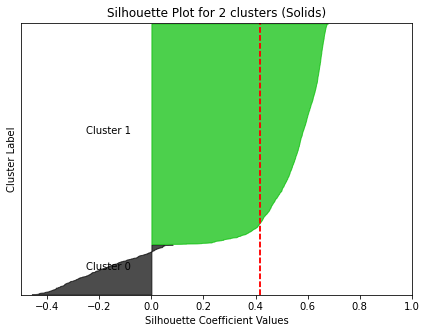

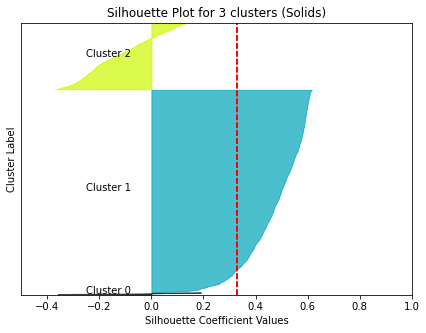

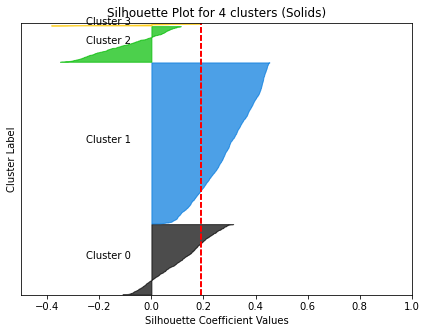

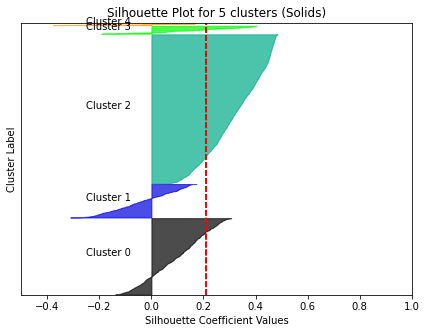

In [18]:
# number of clusters
n_cluster_range = [2,3,4,5]

for n_clusters in n_cluster_range:
    # perform clustering
    pca_data = pca_manifold(revised_df)
    clus_labels = kmeans_clusters(n_clusters)
    
    # create plot
    fig, ax = plt.subplots(figsize = (7,5))
    ax.set_xlim([-0.5,1])
    ax.set_ylim([0, len(pca_data) + (n_clusters + 1) * 10])
    
    # average silhouette score for the dataset
    # a higher silhouette score relates to a model with better defined clusters (bounded between -1 and +1)
    sil_avg = silhouette_score(pca_data, clus_labels)

    # silhouette scores for each sample
    sample_sil_vals = silhouette_samples(pca_data, clus_labels)

    y_lower = 10
    for i in range(n_clusters):
        clus_vals = sample_sil_vals[clus_labels == i]
        clus_vals.sort()

        size_clus_i = clus_vals.shape[0]
        y_upper = y_lower + size_clus_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0,
                         clus_vals,
                         facecolor = color,
                         edgecolor = color,
                         alpha = 0.7
                        )

        ax.text(-0.25, y_lower + 0.5 * size_clus_i, f'Cluster {i}')

        y_lower = y_upper + 10

        # vertical line for average silhouette score of all of the values
        ax.axvline(x = sil_avg, color = 'red', linestyle = '--')

        # no y-axis / ticks
        ax.set_yticks([])
        ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        ax.set_title(f'Silhouette Plot for {n_clusters} clusters (Solids)')
        ax.set_xlabel('Silhouette Coefficient Values')
        ax.set_ylabel('Cluster Label')
    print(f'The average silhouette score for solids with {n_clusters} clusters is: {sil_avg}')
    
plt.show()

In [19]:
revised_df['cluster'] = kmeans_clusters(2)
revised_df.head()

,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),"Fatty acids, total saturated (g)","Fatty acids, total monounsaturated (g)","Fatty acids, total polyunsaturated (g)",Cholesterol (mg),Retinol (mcg),"Vitamin A, RAE (mcg_RAE)","Carotene, alpha (mcg)","Carotene, beta (mcg)","Cryptoxanthin, beta (mcg)",Lycopene (mcg),Lutein + zeaxanthin (mcg),Thiamin (mg),Riboflavin (mg),Niacin (mg),Vitamin B-6 (mg),Folic acid (mcg),"Folate, food (mcg)","Folate, DFE (mcg_DFE)","Folate, total (mcg)","Choline, total (mg)",Vitamin B-12 (mcg),"Vitamin B-12, added\n(mcg)",Vitamin C (mg),Vitamin D (D2 + D3) (mcg),Vitamin E (alpha-tocopherol) (mg),"Vitamin E, added\n(mg)",Vitamin K (phylloquinone) (mcg),Calcium (mg),Phosphorus (mg),Magnesium (mg),Iron\n(mg),Zinc\n(mg),Copper (mg),Selenium (mcg),Potassium (mg),Sodium (mg),Caffeine (mg),Theobromine (mg),Alcohol (g),4:0\n(g),6:0\n(g),8:0\n(g),10:0\n(g),12:0\n(g),14:0\n(g),16:0\n(g),18:0\n(g),16:1\n(g),18:1\n(g),20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g),Is Liquid,cluster
Main food description,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Abalone,177,21.24,7.46,0.00,0.0,6.12,0.877,2.326,2.116,106,2,2,0,0,0,0,0,0.201,0.118,1.770,0.168,0,5,5,5,80.7,0.77,0.0,2.0,0.0,5.95,0.0,33.8,39,236,60,3.97,1.02,0.243,55.6,310,574,0,0,0.0,0.0,0.0,0.0,0.000,0.000,0.031,0.624,0.175,0.043,2.245,0.035,0.0,1.768,0.226,0.007,0.000,0.061,0.051,0.0,62.72,0,1
"Adobo, with noodles",172,16.89,8.14,0.03,0.4,7.66,2.479,3.469,0.973,72,4,4,0,0,0,0,0,0.192,0.204,3.059,0.216,0,3,3,3,57.1,0.43,0.0,0.0,0.3,0.20,0.0,0.0,15,149,18,0.99,2.39,0.085,23.1,200,510,0,0,0.0,0.0,0.0,0.0,0.004,0.004,0.071,1.677,0.697,0.353,3.072,0.040,0.0,0.867,0.046,0.000,0.040,0.000,0.000,0.0,65.27,0,1
"Adobo, with rice",181,17.69,8.86,0.03,0.2,7.94,2.580,3.607,1.022,75,4,4,0,0,0,0,0,0.242,0.213,3.589,0.250,17,4,33,21,59.2,0.44,0.0,0.0,0.4,0.21,0.0,0.0,18,161,21,1.34,2.54,0.096,24.6,216,522,0,0,0.0,0.0,0.0,0.0,0.005,0.004,0.074,1.749,0.722,0.366,3.196,0.041,0.0,0.909,0.050,0.000,0.041,0.000,0.000,0.0,63.34,0,1
Agave liquid sweetener,310,0.09,76.37,68.03,0.2,0.45,0.000,0.000,0.000,0,0,8,0,94,0,0,0,0.122,0.165,0.689,0.234,0,30,30,30,13.3,0.00,0.0,17.0,0.0,0.98,0.0,22.5,1,1,1,0.09,0.01,0.009,1.7,4,4,0,0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,22.94,0,1
"Alfalfa sprouts, raw",23,3.99,2.10,0.20,1.9,0.69,0.069,0.056,0.409,0,0,8,6,87,6,0,0,0.076,0.126,0.481,0.034,0,36,36,36,14.4,0.00,0.0,8.2,0.0,0.02,0.0,30.5,32,70,27,0.96,0.92,0.157,0.6,79,6,0,0,0.0,0.0,0.0,0.0,0.000,0.000,0.002,0.059,0.008,0.000,0.056,0.000,0.0,0.234,0.175,0.000,0.000,0.000,0.000,0.0,92.82,0,1


In [20]:
clus_0 = revised_df[revised_df['cluster'] == 0]
clus_1 = revised_df[revised_df['cluster'] == 1]

In [21]:
clus_0.describe()

,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),"Fatty acids, total saturated (g)","Fatty acids, total monounsaturated (g)","Fatty acids, total polyunsaturated (g)",Cholesterol (mg),Retinol (mcg),"Vitamin A, RAE (mcg_RAE)","Carotene, alpha (mcg)","Carotene, beta (mcg)","Cryptoxanthin, beta (mcg)",Lycopene (mcg),Lutein + zeaxanthin (mcg),Thiamin (mg),Riboflavin (mg),Niacin (mg),Vitamin B-6 (mg),Folic acid (mcg),"Folate, food (mcg)","Folate, DFE (mcg_DFE)","Folate, total (mcg)","Choline, total (mg)",Vitamin B-12 (mcg),"Vitamin B-12, added\n(mcg)",Vitamin C (mg),Vitamin D (D2 + D3) (mcg),Vitamin E (alpha-tocopherol) (mg),"Vitamin E, added\n(mg)",Vitamin K (phylloquinone) (mcg),Calcium (mg),Phosphorus (mg),Magnesium (mg),Iron\n(mg),Zinc\n(mg),Copper (mg),Selenium (mcg),Potassium (mg),Sodium (mg),Caffeine (mg),Theobromine (mg),Alcohol (g),4:0\n(g),6:0\n(g),8:0\n(g),10:0\n(g),12:0\n(g),14:0\n(g),16:0\n(g),18:0\n(g),16:1\n(g),18:1\n(g),20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g),Is Liquid,cluster
count,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0000,821.0,821.0
mean,410.5457,13.6826,36.0228,11.7602,3.2805,24.1872,7.5578,8.7917,5.7804,42.7600,109.9988,116.1145,7.4665,67.9330,2.7917,55.9866,100.6638,0.3498,0.3565,4.6304,0.3155,34.8136,34.8672,93.9622,69.6309,46.6480,0.9963,0.1623,4.6901,1.1245,3.0391,0.5682,11.3205,167.4616,269.5091,66.4665,3.4839,2.4522,0.3321,19.9605,343.1742,521.5079,13.1255,19.1218,0.0,0.1001,0.0643,0.0951,0.1393,0.5120,0.6117,3.9243,1.8388,0.2857,8.3838,0.1077,0.0174,5.2250,0.4077,0.0035,0.0250,0.0252,0.0110,0.0367,23.2754,0.0,0.0
std,112.5209,9.7755,25.9748,15.3644,4.2776,13.7030,5.1215,7.2280,6.4406,90.1635,419.2311,423.1028,123.0457,642.7792,12.4180,465.0280,313.5989,0.9943,0.7234,6.8461,0.4675,129.6056,96.7898,256.3031,175.3316,62.7759,3.8226,0.8630,16.5526,2.9548,5.2734,3.8984,24.2860,230.4418,205.6625,85.5835,6.1222,4.5144,0.7542,68.5911,392.4782,403.3034,228.0304,93.4317,0.0,0.2100,0.1209,0.2537,0.2648,1.6013,0.8685,2.3451,1.6505,0.5525,7.0591,0.2212,0.1923,5.9841,1.0977,0.0194,0.0562,0.1433,0.0427,0.2041,20.8410,0.0,0.0
min,74.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
25%,319.0000,6.6000,11.0500,0.7800,0.3000,16.4100,4.0270,4.6500,1.5470,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0950,0.1460,1.5000,0.0740,0.0000,9.0000,17.0000,16.0000,15.4000,0.0000,0.0000,0.0000,0.0000,0.4600,0.0000,1.9000,28.0000,138.0000,21.0000,1.2100,0.8000,0.0740,7.3000,143.0000,280.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0030,0.0470,2.2670,0.7900,0.0280,4.1840,0.0110,0.0000,1.3000,0.0930,0.0000,0.0000,0.0000,0.0000,0.0000,3.1400,0.0,0.0
50%,403.0000,11.1000,33.1100,4.1600,2.0000,21.1800,6.7510,7.0040,3.5770,12.0000,10.0000,13.0000,0.0000,2.0000,0.0000,0.0000,10.0000,0.2080,0.2350,3.1800,0.1520,0.0000,18.0000,46.0000,38.0000,31.6000,0.2200,0.0000,0.0000,0.0000,1.4000,0.0000,4.2000,70.0000,217.0000,33.0000,2.1200,1.5900,0.1220,13.7000,232.0000,438.000

In [22]:
clus_1.describe()

,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),"Fatty acids, total saturated (g)","Fatty acids, total monounsaturated (g)","Fatty acids, total polyunsaturated (g)",Cholesterol (mg),Retinol (mcg),"Vitamin A, RAE (mcg_RAE)","Carotene, alpha (mcg)","Carotene, beta (mcg)","Cryptoxanthin, beta (mcg)",Lycopene (mcg),Lutein + zeaxanthin (mcg),Thiamin (mg),Riboflavin (mg),Niacin (mg),Vitamin B-6 (mg),Folic acid (mcg),"Folate, food (mcg)","Folate, DFE (mcg_DFE)","Folate, total (mcg)","Choline, total (mg)",Vitamin B-12 (mcg),"Vitamin B-12, added\n(mcg)",Vitamin C (mg),Vitamin D (D2 + D3) (mcg),Vitamin E (alpha-tocopherol) (mg),"Vitamin E, added\n(mg)",Vitamin K (phylloquinone) (mcg),Calcium (mg),Phosphorus (mg),Magnesium (mg),Iron\n(mg),Zinc\n(mg),Copper (mg),Selenium (mcg),Potassium (mg),Sodium (mg),Caffeine (mg),Theobromine (mg),Alcohol (g),4:0\n(g),6:0\n(g),8:0\n(g),10:0\n(g),12:0\n(g),14:0\n(g),16:0\n(g),18:0\n(g),16:1\n(g),18:1\n(g),20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g),Is Liquid,cluster
count,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0,3651.0000,3651.000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000,3651.0,3651.0
mean,172.9474,8.4996,20.1658,5.5870,1.7422,6.6095,1.8734,2.3636,1.6296,39.2832,23.1630,54.1296,62.2512,336.6519,6.9162,336.3961,293.8113,0.1481,0.1505,2.3195,0.1636,12.8455,22.2054,43.8729,34.9104,36.1127,0.4165,0.0156,6.1722,0.3026,0.8081,0.0052,19.1863,56.3511,116.3328,23.5585,1.4264,1.0180,0.1056,12.8313,205.9414,345.7998,0.2356,0.9362,0.0,0.0214,0.015,0.0106,0.0246,0.0349,0.1244,1.1188,0.4611,0.1139,2.2101,0.0267,0.0024,1.4198,0.1571,0.0009,0.0138,0.0055,0.0028,0.0089,63.1676,0.0,1.0
std,93.0198,7.0807,20.0763,11.9859,1.8624,5.1132,1.7019,2.0847,1.6989,87.3822,45.1149,101.6635,313.7424,1042.2863,51.3874,1324.5902,1195.8495,0.1644,0.1288,2.1516,0.1495,24.4517,24.9568,47.9199,34.4322,45.6267,1.0247,0.1522,16.7267,0.9116,0.7519,0.0873,71.6968,72.1803,81.4013,18.0159,1.6965,1.5173,0.1347,11.7927,130.8510,306.9351,10.0993,10.3039,0.0,0.0424,0.030,0.0234,0.0449,0.1045,0.1811,0.9815,0.4788,0.1642,1.9568,0.0388,0.0273,1.5072,0.1906,0.0060,0.0274,0.0254,0.0108,0.0459,20.6951,0.0,0.0
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,1.0
25%,107.0000,2.6700,6.0050,0.6200,0.5000,2.5800,0.5290,0.7350,0.4850,0.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0540,0.0600,0.7075,0.0760,0.0000,8.0000,11.0000,11.0000,11.1000,0.0000,0.0000,0.0000,0.0000,0.2700,0.0000,1.5000,15.0000,54.0000,14.0000,0.5650,0.3900,0.0540,2.1000,125.0000,188.0000,0.0000,0.0000,0.0,0.0000,0.000,0.0000,0.0000,0.0000,0.0060,0.3505,0.1100,0.0120,0.7055,0.0040,0.0000,0.3860,0.0420,0.0000,0.0000,0.0000,0.0000,0.0000,53.5300,0.0,1.0
50%,160.0000,7.0200,15.3400,1.7500,1.3000,5.5800,1.3090,1.9050,1.1350,14.0000,5.0000,17.0000,0.0000,14.0000,0.0000,0.0000,32.0000,0.0930,0.1170,1.6750,0.1200,0.0000,14.0000,29.0000,26.0000,21.2000,0.1200,0.0000,0.9000,0.0000,0.5800,0.0000,4.5000,30.0000,101.0000,20.0000

In [23]:
# Davies-Bouldin Score - siginifes average 'similarity' between clusters, where the similarity is a measure that compares
# distance between clusters with the size of the clusters themselves

# lower score relates to a model with a better partition
clus_labels = np.array(revised_df['cluster'])

db_score = davies_bouldin_score(pca_data, clus_labels)
db_score

2.11369074109625

In [24]:
# Calinski-Harabasz Index - the ratio of the mean between-cluster dispersion and the inter-cluster dispersion for all 
# clusters (where dispersion is defined as the sum of distances squared)

# higher score relates to a model with better defined clusters
ch_score = calinski_harabasz_score(pca_data, clus_labels)
ch_score

560.9484714317579

In [25]:
junk_parameters = ['Energy (kcal)', 'Sodium (mg)', 'Sugars, total\n(g)', 'Total Fat (g)']

clus_0[junk_parameters].describe()

,Energy (kcal),Sodium (mg),"Sugars, total\n(g)",Total Fat (g)
count,821.0000,821.0000,821.0000,821.0000
mean,410.5457,521.5079,11.7602,24.1872
std,112.5209,403.3034,15.3644,13.7030
min,74.0000,0.0000,0.0000,0.0000
25%,319.0000,280.0000,0.7800,16.4100
50%,403.0000,438.0000,4.1600,21.1800
75%,487.0000,704.0000,20.5200,29.3400
max,892.0000,3668.0000,84.8300,100.0000


In [26]:
clus_1[junk_parameters].describe()

,Energy (kcal),Sodium (mg),"Sugars, total\n(g)",Total Fat (g)
count,3651.0000,3651.0000,3651.0000,3651.0000
mean,172.9474,345.7998,5.5870,6.6095
std,93.0198,306.9351,11.9859,5.1132
min,0.0000,0.0000,0.0000,0.0000
25%,107.0000,188.0000,0.6200,2.5800
50%,160.0000,323.0000,1.7500,5.5800
75%,235.0000,443.0000,4.1000,10.1250
max,465.0000,7851.0000,99.8000,24.7800
